In [4]:
import pandas as pd

# load data
df = pd.read_csv("../data/personal_finance_expenses.csv")

df.columns.tolist()

cluster_features = [
    "Income",
    "Disposable_Income",
    "Desired_Savings",
    "Groceries",
    "Transport",
    "Entertainment"
]

X_cluster = df[cluster_features].copy()
X_cluster.describe().T

,count,mean,std,min,25%,50%,75%,max
Income,20000.0,41585.496104,40014.540538,1301.187333,17604.875957,30185.383480,51765.446460,1.079728e+06
Disposable_Income,20000.0,10647.367257,11740.637289,-5400.788673,3774.894323,7224.890977,13331.950716,3.770602e+05
Desired_Savings,20000.0,4982.878416,7733.468188,0.000000,1224.932636,2155.356763,6216.309609,2.455045e+05
Groceries,20000.0,5205.667493,5035.953689,154.078240,2165.426419,3741.091535,6470.892718,1.198169e+05
Transport,20000.0,2704.466685,2666.345648,81.228584,1124.578012,1933.845509,3360.597508,8.186150e+04
Entertainment,20000.0,1448.853658,1489.019270,45.421469,581.632906,1020.198376,1790.104082,3.866737e+04


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

import pandas as pd
X_scaled = pd.DataFrame(X_scaled, columns=cluster_features)

X_scaled.describe().T


,count,mean,std,min,25%,50%,75%,max
Income,20000.0,1.403322e-16,1.000025,-1.006767,-0.599313,-0.284906,0.254413,25.944790
Disposable_Income,20000.0,2.842171e-18,1.000025,-1.366924,-0.585372,-0.291514,0.228663,31.209721
Desired_Savings,20000.0,3.694822e-17,1.000025,-0.644343,-0.485945,-0.365631,0.159497,31.102167
Groceries,20000.0,9.805490e-17,1.000025,-1.003130,-0.603722,-0.290831,0.251245,22.759164
Transport,20000.0,1.005418e-16,1.000025,-0.983857,-0.592544,-0.289025,0.246085,29.688205
Entertainment,20000.0,2.174261e-16,1.000025,-0.942545,-0.582425,-0.287885,0.229184,24.995946


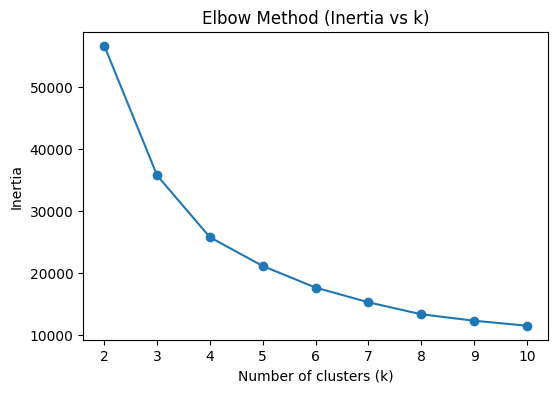

In [21]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
ks = range(2, 11)  # try k=2..10

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    km.fit(X_scaled)
    inertias.append(km.inertia_)  # inertia = sum of squared distances to cluster centers

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Method (Inertia vs k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()


done k=2, silhouette=0.718
done k=3, silhouette=0.587
done k=4, silhouette=0.558
done k=5, silhouette=0.485
done k=6, silhouette=0.459


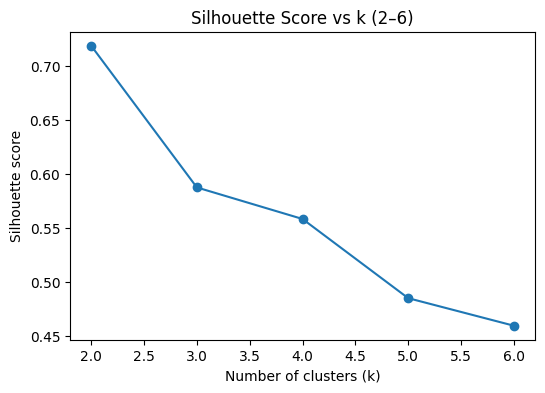

In [22]:
from sklearn.metrics import silhouette_score

silhouettes = []
ks = range(2, 7)  # narrower range

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = km.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouettes.append(score)
    print(f"done k={k}, silhouette={score:.3f}")

plt.figure(figsize=(6,4))
plt.plot(ks, silhouettes, marker='o')
plt.title("Silhouette Score vs k (2–6)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.show()


In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

# 1) fit KMeans (k=3)
k = 3
km = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = km.fit_predict(X_scaled)

# 2) quality + sizes
sil = silhouette_score(X_scaled, labels)
print(f"KMeans k={k} — silhouette: {sil:.3f}")

# attach to original df for later use
df['cluster_k3'] = labels
print("\nCluster sizes:")
print(df['cluster_k3'].value_counts().sort_index())

# 3) centers in original feature UNITS (inverse-transform)
centers_scaled = km.cluster_centers_
centers_orig = pd.DataFrame(
    scaler.inverse_transform(centers_scaled),
    columns=cluster_features
).round(2)

print("\nCluster centers (original units):")
centers_orig


KMeans k=3 — silhouette: 0.587

Cluster sizes:
cluster_k3
0    14571
1      718
2     4711
Name: count, dtype: int64

Cluster centers (original units):


,Income,Disposable_Income,Desired_Savings,Groceries,Transport,Entertainment
0,24197.31,6004.83,1992.01,3029.89,1571.47,835.62
1,183288.01,49723.87,34889.09,22975.68,11975.41,6461.69
2,73610.30,19008.59,9649.09,9207.00,4785.44,2575.93


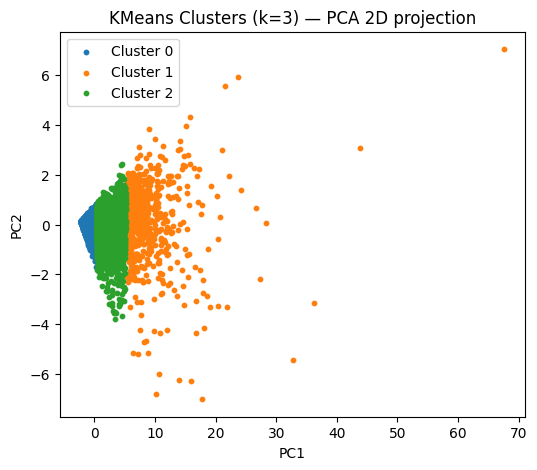

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
for c in sorted(df['cluster_k3'].unique()):
    plt.scatter(
        X_pca[df['cluster_k3']==c, 0],
        X_pca[df['cluster_k3']==c, 1],
        s=10, label=f"Cluster {c}"
    )

plt.title("KMeans Clusters (k=3) — PCA 2D projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()


In [25]:
# cluster profiles: mean values per cluster
profile = df.groupby("cluster_k3")[cluster_features].mean().round(2)

# add cluster sizes
profile["Count"] = df["cluster_k3"].value_counts().sort_index().values

profile


,Income,Disposable_Income,Desired_Savings,Groceries,Transport,Entertainment,Count
cluster_k3,,,,,,,
0,24221.87,6008.80,1994.66,3032.93,1573.03,836.47,14571
1,183383.37,49743.14,34898.32,22987.44,11980.23,6465.38,718
2,73679.44,19035.76,9665.96,9215.78,4790.25,2578.37,4711


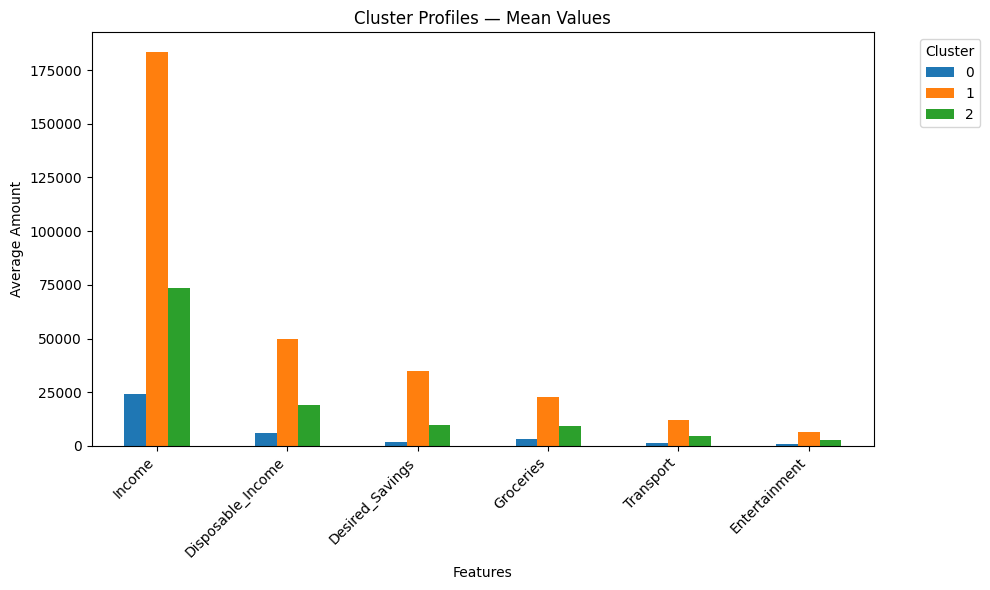

In [26]:
import matplotlib.pyplot as plt

# drop Count column for plotting
plot_data = profile.drop(columns="Count").T

plot_data.plot(kind="bar", figsize=(10,6))
plt.title("Cluster Profiles — Mean Values")
plt.ylabel("Average Amount")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [28]:
# 1) save the dataframe with cluster labels
df.to_csv("../outputs/05_clustered_data.csv", index=False)

# 2) save the cluster profile table
profile.to_csv("../outputs/05_cluster_profiles.csv")

print("✅ clustering results saved to ../outputs/")


✅ clustering results saved to ../outputs/


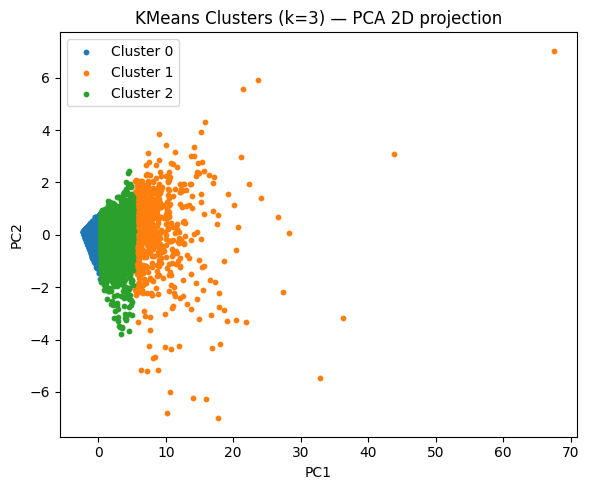

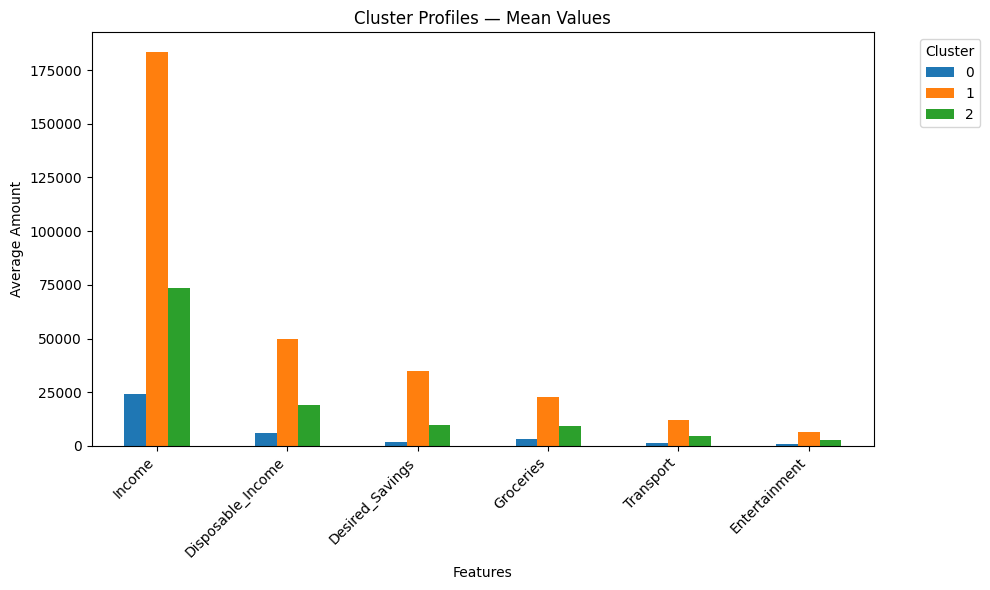

In [29]:
# PCA scatterplot
plt.figure(figsize=(6,5))
for c in sorted(df['cluster_k3'].unique()):
    plt.scatter(
        X_pca[df['cluster_k3']==c, 0],
        X_pca[df['cluster_k3']==c, 1],
        s=10, label=f"Cluster {c}"
    )

plt.title("KMeans Clusters (k=3) — PCA 2D projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/05_clusters_pca.png", dpi=300)
plt.show()

# Cluster profile bar chart
plot_data.plot(kind="bar", figsize=(10,6))
plt.title("Cluster Profiles — Mean Values")
plt.ylabel("Average Amount")
plt.xlabel("Features")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("../outputs/05_cluster_profiles.png", dpi=300)
plt.show()
